In [27]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


basepath = '../CarND-Behavioral-Cloning-P3/traindata/'
myfile = basepath+'driving_log.csv'

print('Loading data from: ',myfile)

df = pd.read_csv(myfile)
headers = df.columns
images=[]
measurements = []
speed = []


for row in df.itertuples():
    
    source_path = getattr(row,headers[0])

    filename = source_path.split('\\')[-1]
    current_path = basepath+'IMG/' + filename

    image = cv2.imread(current_path)
    images.append(image)

    measurement = float(getattr(row,headers[3]))
    measurements.append(measurement)
    
print('Loading data complete...')


Loading data from:  ../CarND-Behavioral-Cloning-P3/traindata/driving_log.csv
Loading data complete...


In [28]:
print(df.shape)


(8503, 7)


In [29]:
# Set up some common parameters and function

camera_views = [0,1,2]
# Define correction angle for steering. 
# 0 - straight     : 0.0 
# 1 - left camera  : 0.2 
# 2 - right camera : -0.2
correction_factor = {0: 0.0 , 1: 0.2, 2: - 0.2}

def get_image(row,selected_camera_view):
    source_path = row.get_value(headers[selected_camera_view])
    filename = source_path.split('\\')[-1]
    current_path = basepath+'IMG/' + filename
    image = plt.imread(current_path)
    measurement = float(row.get_value(headers[3])) + correction_factor[selected_camera_view]    

    return image, measurement
    

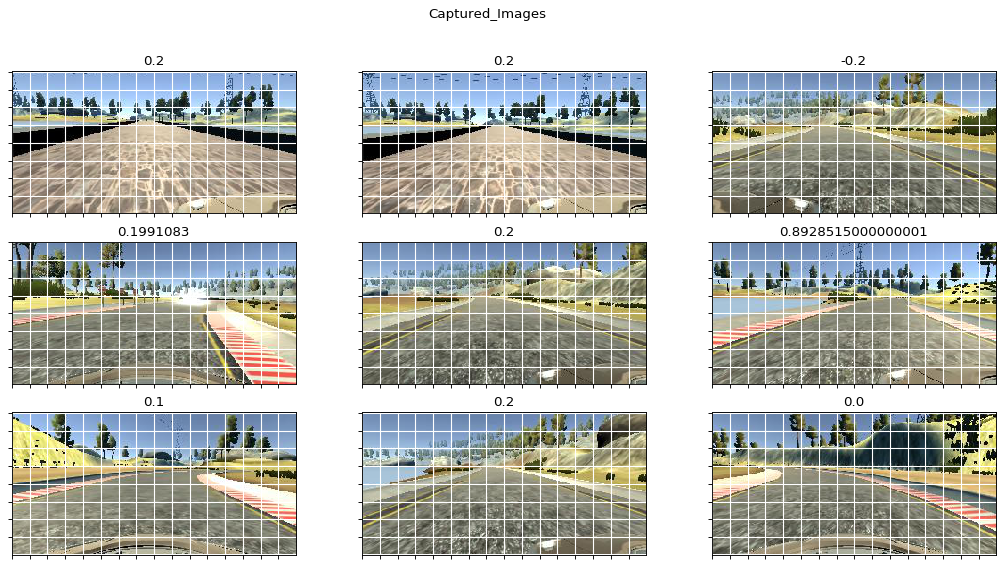

Shape of each image is:  (160, 320, 3)
Based on these images, we should crop the image from top and bottom.
The bonnet and environment should not affect when we should be steering.


In [30]:
# Visualize the data. Plot some of the images along with the measured steering angles

fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')


for i in range(9):
    idx = np.random.randint(0,len(measurements))
    #Select which of the three cameras to use
    selected_camera_view = np.random.choice(camera_views,1)[0]

    # Pick that row from the data file:
    row = df.iloc[idx]

    # Get the image and measurement 
    image, measurement = get_image(row,selected_camera_view)
    
    plt.subplot(3,3,i+1), plt.title(measurement)
    plt.imshow(image)
    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, 320, 20));
    ax.set_yticks(np.arange(0, 160, 20));
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    # Gridlines based on minor ticks
    ax.grid(which='major', color='w', linestyle='-', linewidth=1)

plt.suptitle('Captured_Images')
plt.show()
image_rows,image_col,image_channels = image.shape
print('Shape of each image is: ', image.shape)
print('Based on these images, we should crop the image from top and bottom.')
print('The bonnet and environment should not affect when we should be steering.')


In [31]:
fig.savefig('./images/image1_visualize_data.png',bbox_inches='tight', pad_inches=0)


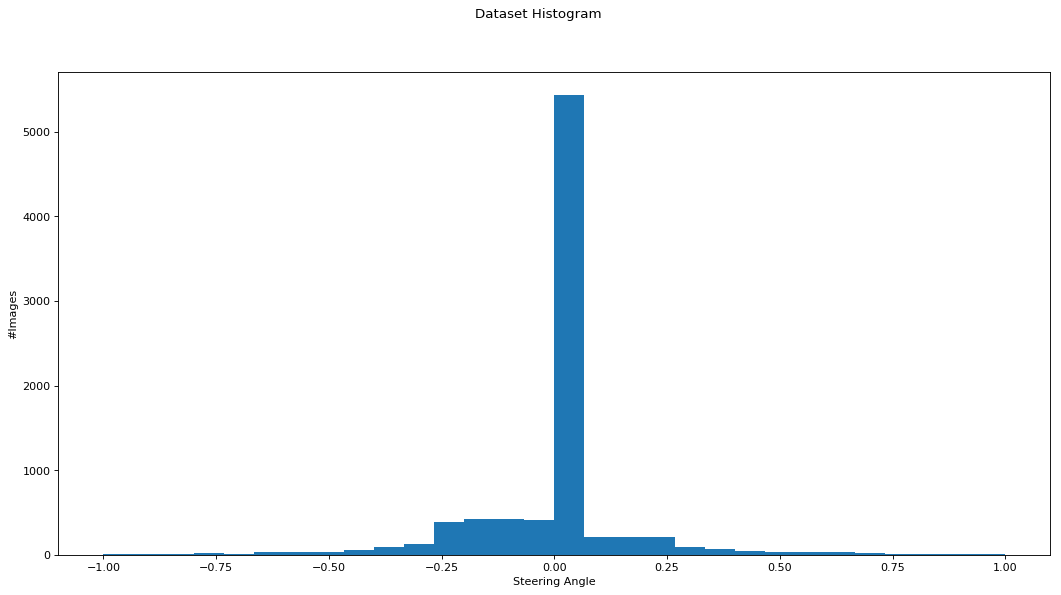


Total training data images = 8503


In [32]:
# Plot the histogram of the data to see data distribution:
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

n,bin,patches = plt.hist(measurements,30)
plt.xlabel('Steering Angle'), plt.ylabel('#Images')
plt.suptitle('Dataset Histogram')
plt.show()

print()
print("Total training data images = {}".format(len(measurements)))

In [33]:
fig.savefig('./images/image3_histogram_dataset.png',bbox_inches='tight', pad_inches=0)

**Observation:**
Lot of images are at ~0 steering, which makes sense. Need to figure out a way to reduce the sampling from these images, or augment remaining data.

## Test some image augmentation techniques

### Technique 1: Image Cropping

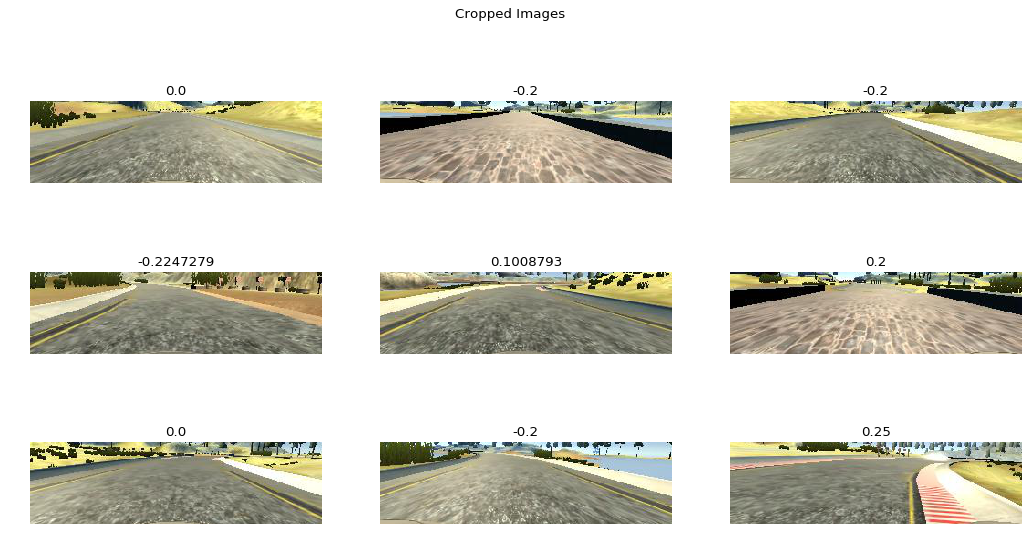

Shape of output is  (90, 320, 3)
After trial and error,I have decided to shave off 50 px from top and 20 px from bottom 


In [34]:
# Technique 1: Testing image cropping
crop_top_pixels = 50
crop_bottom_pixels = 20
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

from keras import backend as K
from keras.layers.convolutional import Cropping2D
from keras.models import Sequential

# with a Sequential model
model = Sequential()
model.add(Cropping2D(cropping=((crop_top_pixels, crop_bottom_pixels), (0, 0)), input_shape=(160, 320, 3)))
cropping_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])

for i in range(9):
    idx = np.random.randint(0,len(measurements))
    #Select which of the three cameras to use
    selected_camera_view = np.random.choice(camera_views,1)[0]

    # Pick that row from the data file:
    row = df.iloc[idx]

    # Get the image and measurement 
    image, measurement = get_image(row,selected_camera_view)
    
    # Crop the images using the keras function
    cropped_image = cropping_output([image[None,...]])[0]
    cropped_image = cropped_image[0].astype('uint8')

    # Or we can use slicing 
    # image1 = image[crop_top_pixels:(image_rows - crop_bottom_pixels)]
    # image1 = image[50:140,0:320]    
    # plt.subplot(3,3,i+1), plt.imshow(image1)
    # plt.axis('off')
    
    plt.subplot(3,3,i+1)
    plt.title(measurement), plt.imshow(cropped_image)
    plt.axis('off')
    
plt.suptitle('Cropped Images')
plt.show()
print('Shape of output is ',cropped_image.shape)

print('After trial and error,I have decided to shave off 50 px from top and 20 px from bottom ')



In [35]:
fig.savefig('./images/image2_cropped_images.png',bbox_inches='tight', pad_inches=0)

**Observation:**
We should crop the image in the keras model so that the model doesn't learn the environment related data.

### Technique 2: Translate images horizontally and vertically

In [36]:
# Use Keras ImageDataGenerator to translate the images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img

datagen = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    fill_mode = 'constant',cval=0.0
)


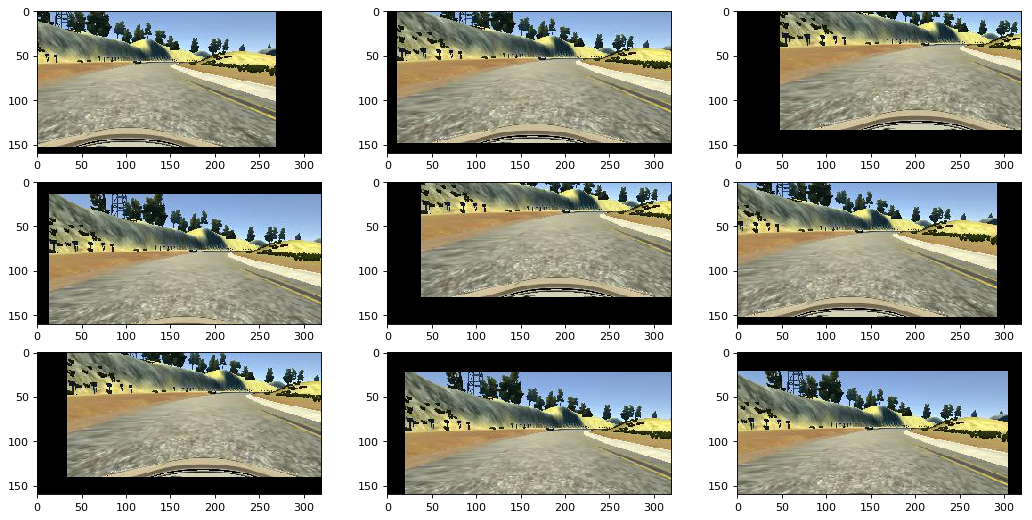

In [37]:

fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
idx = np.random.randint(0,5000)

selected_camera_view = np.random.choice(camera_views,1)[0]
row = df.iloc[idx]

# Get the image and measurement 
image, measurement = get_image(row,selected_camera_view)

x = image.reshape((1,)+image.shape )

i = 0
# Use the flow command
for batch in datagen.flow(x,batch_size=1):
    plt.subplot(3,3,i+1)
    plt.imshow(batch[0])
    i = i+1
    if i==9:
        break

**Using this image generator will work  well in normal circumstances. But We need to also change the measurement value based on the horizontal shifts. Can't seem to do that in the image generator. Bummer~**

**So will have to write my own translate_image function.**


In [38]:
def translate_image(image,measurement,del_x,del_y,steer_per_px):
    rows,cols,depth = image.shape
    
    # Change in x and y will be +- del_x or +- del_y
    change_x = del_x * np.random.uniform(-1,1)
    change_y = del_y * np.random.uniform(-1,1)
    
    new_steer = measurement + change_x * steer_per_px
    
    Trans_M = np.float32([[1,0,change_x],[0,1,change_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,new_steer

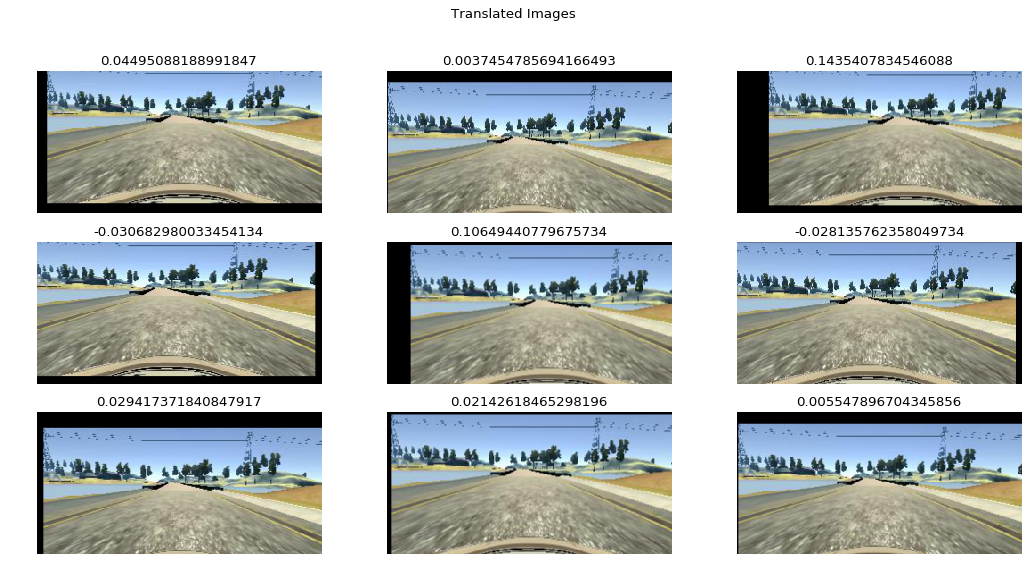

In [39]:
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

idx = np.random.randint(0,5000)
selected_camera_view = np.random.choice(camera_views,1)[0]
row = df.iloc[idx]

# Get the image and measurement 
image, measurement = get_image(row,selected_camera_view)
plt.suptitle('Translated Images')

for i in range(0,9):

    plt.subplot(3,3,i+1), plt.axis('off')

    #Translate the image
    new_image,new_measurement = translate_image(image,measurement,50,20,0.004)
    plt.title(new_measurement)
    plt.imshow(new_image)
    

In [40]:
fig.savefig('./images/image4_translate_image.png',bbox_inches='tight', pad_inches=0)

### Technique 3: Brightness augmentation

In [41]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    #all values are uint8. Change that to float32 so that we can multiply by random generator
    image1 = image1.astype('float32')
    intensity = image1[:,:,2]
    # Lets get random intensity between 0.3 - 1.3 times the actual intensity. 
    # Can go brighter, but making an assumption that the new images will be darker than originals
    intensity_correction = np.random.uniform(0.3,1.3)
    new_intensity = intensity * intensity_correction
    image2 = image1
    image2[:,:,2] = new_intensity
    # convert back to uint8
    image2 = image2.astype('uint8')
    
    image2 = cv2.cvtColor(image2,cv2.COLOR_HSV2RGB)
    return image2, intensity_correction


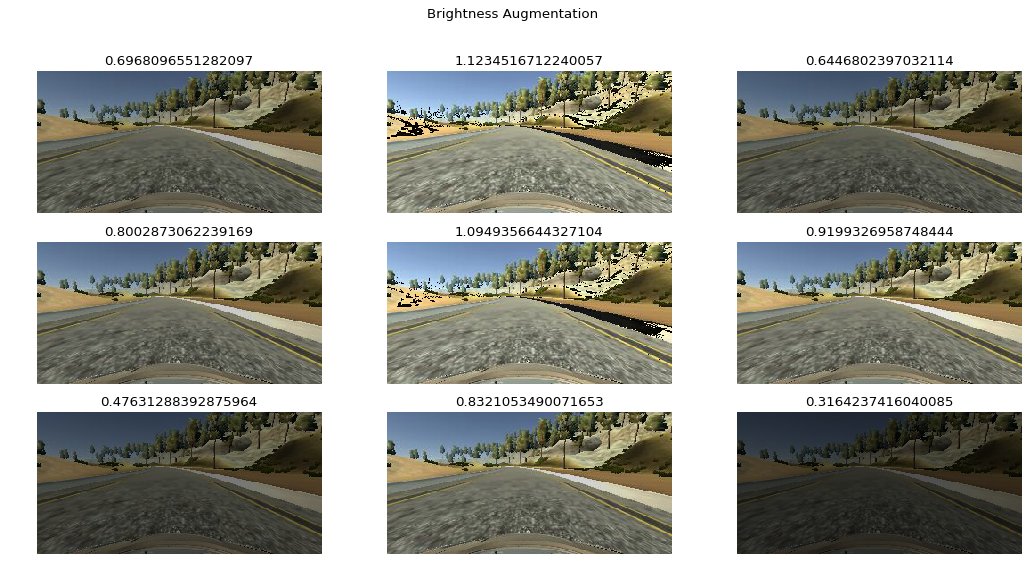

In [42]:
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

idx = np.random.randint(0,1000)
row  = df.iloc[idx]

# Get the image and measurement 
image, measurement = get_image(row,selected_camera_view)

plt.suptitle('Brightness Augmentation')

for i in range(0,9):
    plt.subplot(3,3,i+1), plt.axis('off')

    #Translate the image
    new_image,intensity_correction = augment_brightness(image)
    plt.title(intensity_correction)
    plt.imshow(new_image)
    

In [43]:
fig.savefig('./images/image5_brightness_augmentation.png',bbox_inches='tight', pad_inches=0)

### Technique 4: Horizontal Flipping

In [44]:
def flip_image(image,measurement):
    new_image = np.fliplr(image)
    new_measurement = -1.0 * measurement
    
    return new_image, new_measurement


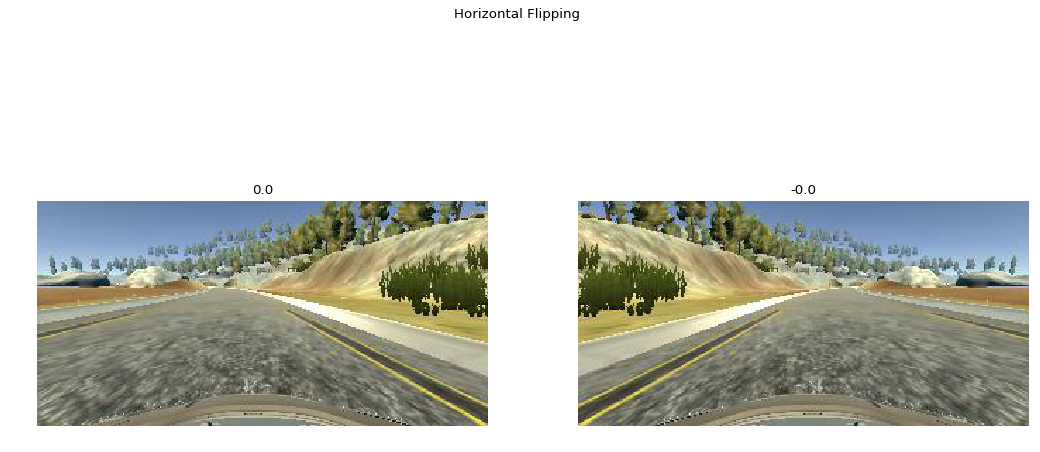

In [45]:
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

idx = np.random.randint(0,1000)
row  = df.iloc[idx]

# Get the image and measurement 
image, measurement = get_image(row,selected_camera_view)# print(image.shape)

plt.suptitle('Horizontal Flipping')

#Plot the original image
plt.subplot(1,2,1), plt.axis('off')
plt.title(measurement)
plt.imshow(image)

#Plot the flipped image
flipped_image,flipped_measurement = flip_image(image,measurement)

plt.subplot(1,2,2), plt.axis('off')
plt.title(flipped_measurement)
plt.imshow(flipped_image)

    

In [46]:
fig.savefig('./images/image6_horizontal_flipping.png',bbox_inches='tight', pad_inches=0)

## End of testing image augmentation techniques. 


** Now that we have looked at some of the image augmentation/ preprocessing techniques, let's start actually implementing the neural network!

In [47]:
idx_vector = np.arange(0,df.shape[0])

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(idx_vector, test_size=0.2)


print('Number of training samples :' , len(train_samples))

print('Number of validation samples :' , len(validation_samples))



Number of training samples : 6802
Number of validation samples : 1701


## Create the Keras model

In [48]:
#Start creating the keras model
batch_size = 32
pool_size = (2,2)

from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten,Dense, Dropout
from keras.layers.convolutional import Cropping2D
from keras.layers.pooling import MaxPooling2D

model  = Sequential()

model.add(Cropping2D(cropping=((crop_top_pixels, crop_bottom_pixels), (1, 1)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/255.0 - 0.5))

model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())

model.add(Dense(output_dim= 100 , activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(output_dim= 50 , activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(output_dim= 10 , activation='relu'))

# Notice, no activation since regresison.
model.add(Dense(output_dim= 1))



## Make the keras generator function

In [49]:
import sklearn
def generator(samples,batch_size=32):
    
    num_samples = len(samples)
    
    while 1:
        
        sklearn.utils.shuffle(samples)
        for offset in range(0,num_samples,batch_size):
            batch_samples = samples[offset:offset+batch_size]
        
            images = []
            measurements = []
            for batch_sample in batch_samples:

                #Select which of the three cameras to use
                selected_camera_view = np.random.choice(camera_views,1)[0]

                # Pick that row from the data file:
                row = df.iloc[batch_sample]

                # Get the image and measurement 
                image, measurement = get_image(row,selected_camera_view)# print(image.shape)

                # Now that we have the camera view and measurement, 
                # apply the image augmentation techniques
                
                new_image = image
                new_measurement = measurement

                # randomly flip the image horizontally
                if (np.random.randint(0,2)==0):
                    new_image,new_measurement = flip_image(new_image,new_measurement)

                # brightness augmentation
                new_image,intensity_correction = augment_brightness(new_image)

                # Translate the image:
                new_image,new_measurement = translate_image(new_image,new_measurement,50,20,0.004)

                images.append(new_image)
                measurements.append(new_measurement)
        
            x_batch = np.array(images)
            y_batch = np.array(measurements)

            output = sklearn.utils.shuffle(x_batch, y_batch)
            yield output


In [50]:
train_generator = generator(train_samples,batch_size)
validation_generator = generator(validation_samples,batch_size)


In [51]:
#Test the generator. Just confirm if the generator is giving us the data.
my_output = []
for i in range(4):
    my_output = (next(train_generator))

    print(my_output[0].shape)
    print()

(32, 160, 320, 3)

(32, 160, 320, 3)

(32, 160, 320, 3)

(32, 160, 320, 3)



### Start the training

In [58]:
# learning_rate = 0.001
from keras.callbacks import EarlyStopping, TensorBoard

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
]

history = model.fit_generator(train_generator,
                    samples_per_epoch= len(train_samples),
                    validation_data = validation_generator,
                    nb_val_samples = len(validation_samples),
                    nb_epoch=4, callbacks = callbacks)

model.save('model.h5')
                                                        
print('Model Saved')



Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/4
6802/6802 [==============================] - 145s - loss: 0.0353 - acc: 0.0000e+00 - val_loss: 0.0353 - val_acc: 0.0000e+00

In [59]:
print(history.history.keys())


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


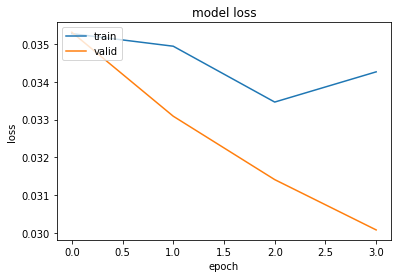

In [62]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()